In [1]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf
using MLUtils
using IterTools: ncycle

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")

Main.Models

# Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

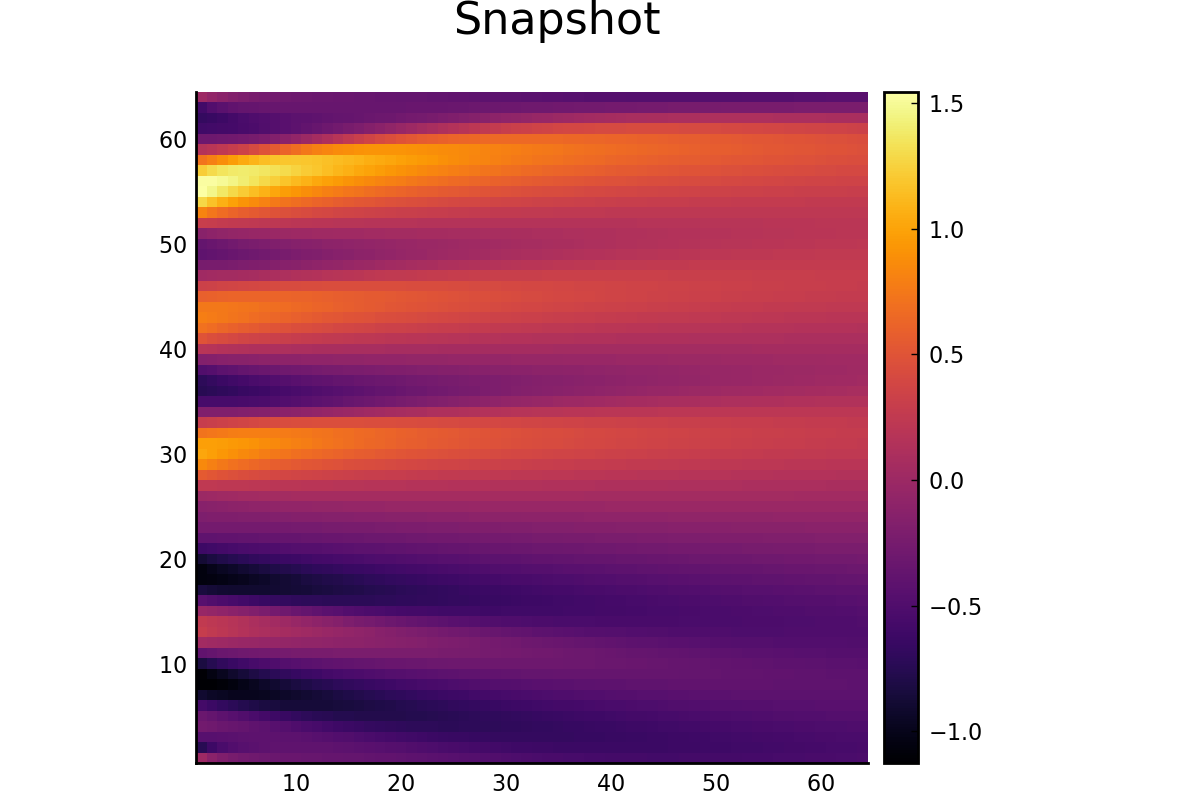

In [2]:
t_max = 0.2;
t_min = 0.;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.01;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

u0 = InitialFunctions.high_dim_random_init(t, x);
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

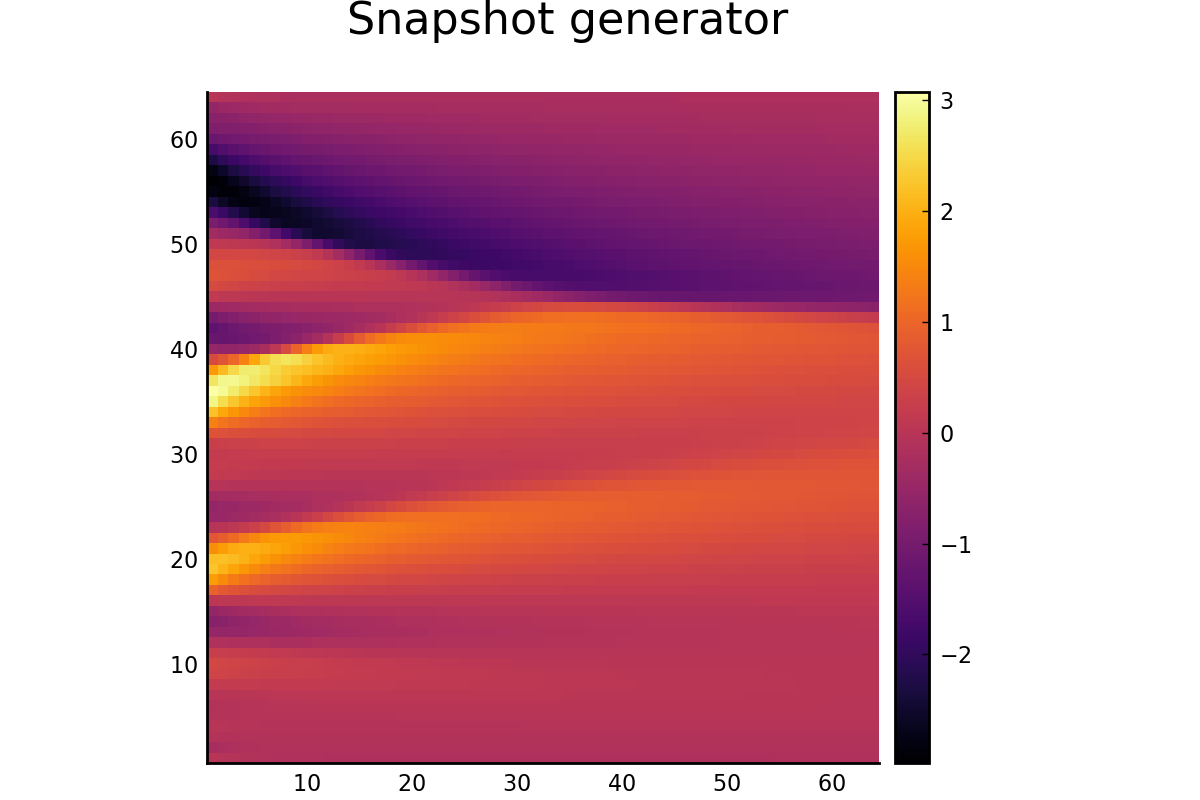

In [3]:
ta, u_a = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
GraphicTools.show_state(u_a, "Snapshot generator")

In [4]:
# dataset = Generator.generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 32, 2, 1, false, "./src/dataset/burgers_high_dim_training_set.jld2", "training_set");
high_dataset = Generator.read_dataset("./src/dataset/burgers_high_dim_training_set.jld2")["training_set"];
# coarse_dataset = Generator.read_dataset("./src/dataset/burgers_coarse_training_set.jld2")["training_set"];

In [ ]:
function check_training_dataset(dataset)
    for i in range(1, 4, step=1)
        a, b = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(high_dataset)

# Training with NeuralODE object

In [5]:
callback(theta, loss, u) = (display(loss); false)

callback (generic function with 1 method)

In [45]:
?Tsit5

search: Tsit5 AutoTsit5 TsitPap8 AutoSwitch startswith methodswith



```
Tsit5(; stage_limiter! = OrdinaryDiffEq.trivial_limiter!,
        step_limiter! = OrdinaryDiffEq.trivial_limiter!,
        thread = OrdinaryDiffEq.False())
```

A fourth-order, five-stage explicit Runge-Kutta method with embedded error estimator of Tsitouras. Free 4th order interpolant.

Like SSPRK methods, this method also takes optional arguments `stage_limiter!` and `step_limiter!`, where `stage_limiter!` and `step_limiter!` are functions of the form `limiter!(u, integrator, p, t)`.

The argument `thread` determines whether internal broadcasting on appropriate CPU arrays should be serial (`thread = OrdinaryDiffEq.False()`, default) or use multiple threads (`thread = OrdinaryDiffEq.True()`) when Julia is started with multiple threads.

## References

@article{tsitouras2011runge,   title={Runge–Kutta pairs of order 5 (4) satisfying only the first column simplifying assumption},   author={Tsitouras, Ch},   journal={Computers \& Mathematics with Applications},   volume={62},   number={2},   pages={770–775},   year={2011},   publisher={Elsevier} }


In [ ]:
function burgers_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.03, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-6 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

In [33]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(u0, res)

    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

check_result (generic function with 1 method)

## Experiment with different models

### Heat linear model

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

In [ ]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

--- 
### FNN

In [ ]:
# t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net2 = Models.BasicFNN(x_n);
result2 = burgers_training(net2, 100, init_set, true_set, t);

In [ ]:
check_result(net2, result2, 2)

### Basic Autoencoder

In [ ]:
net3 = Models.BasicAutoEncoder(x_n);
result3 = burgers_training(net3, 1000, init_set, true_set, t);

In [ ]:
check_result(net3, result3, 2)

## Analysis

In [ ]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

In [ ]:
println(test_simulation(net, result, 1000, 1))
println(test_simulation(net, result, 1000, 2))

In [ ]:
println(test_simulation(net2, result2, 1000, 1))
println(test_simulation(net2, result2, 1000, 2))

In [ ]:
println(test_simulation(net3, result3, 1000, 1))
println(test_simulation(net3, result3, 1000, 2))

## Training with flux

In [13]:
function get_data_loader(dataset, batch_size, ratio)
 t, init_set, true_set = ProcessingTools.process_dataset(dataset, false);
    
  t_train, t_val = splitobs(t, at = ratio);
  train_set, val_set = splitobs(true_set, at = ratio);
  init_train = copy(init_set);
  init_val = copy(val_set[:, :, 1]);

  switch_train_set = permutedims(train_set, (1, 3, 2));
  switch_val_set = permutedims(val_set, (1, 3, 2));
    

  train_loader = DataLoader((init_train, switch_train_set, collect(ncycle([collect(t_train)], batch_size))), batchsize=batch_size, shuffle=false);
  val_loader = DataLoader((init_val, switch_val_set, collect(ncycle([collect(t_val)], batch_size))), batchsize=batch_size, shuffle=false);

  return (train_loader, val_loader)
end

get_data_loader (generic function with 1 method)

In [42]:
function training(model, epochs, dataset, batch_size, ratio)    
    opt = Flux.ADAM(0.01, (0.9, 0.999), 1.0e-8);
    
    @info("Loading dataset")
    (train_loader, val_loader) = get_data_loader(dataset, batch_size, ratio);

    @info("Building model")
    p, re = Flux.destructure(model);
    net(u, p, t) = re(p)(u);
    
    prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));
    
    function predict_neural_ode(x, t)
        tspan = (t[1], t[end]);
        _prob = remake(prob; u0=x, p=p, tspan=tspan);
        Array(solve(_prob, Tsit5(), u0=x, p=p, saveat=t));
    end
    
    function loss(x, y, t)
        u_pred = predict_neural_ode(x, t[1]);
        l = Flux.mse(u_pred, permutedims(y, (1, 3, 2)));
        return l;
    end
    
    function traincb()
        ltrain = 0;
        for (x, y, t) in train_loader
             ltrain += loss(x, y, t);
        end
        ltrain /= (train_loader.nobs / train_loader.batchsize);
        @show(ltrain);
    end
    
    function evalcb()
        lval = 0;
        for (x, y, t) in val_loader
             lval += loss(x, y, t);
        end
        lval /= (val_loader.nobs / val_loader.batchsize);
        @show(lval);
    end
    
    @info("Train")
    Flux.@epochs epochs Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
    
    return model, p
end

training (generic function with 2 methods)

In [43]:
model = Flux.Chain(Flux.Dense(x_n, x_n, identity; bias=false, init=Flux.zeros32))
nn, p = training(model, 100, high_dataset, 32, 0.5);

test

┌ Info: Loading dataset
└ @ Main In[42]:4
┌ Info: Building model
└ @ Main In[42]:7
┌ Info: Train
└ @ Main In[42]:46
┌ Info: Epoch 1
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.37492073953708216
lval = 0.03044603440870284


┌ Info: Epoch 2
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.36700147037940334
lval = 0.030197999457995


┌ Info: Epoch 3
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3593704604053517
lval = 0.029982350610059435
ltrain = 0.3520171374620702
lval = 0.029798616792923907


┌ Info: Epoch 4
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 5
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3449309396824093
lval = 0.02964604369912134


┌ Info: Epoch 6
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3381013730442163
lval = 0.029523501590218607
ltrain = 0.331518081128649
lval = 0.02942953897409078


┌ Info: Epoch 7
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 8
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3251708585532947
lval = 0.029362494539930447


┌ Info: Epoch 9
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3190497197271723
lval = 0.029320521816753115
ltrain = 0.3131449580006239
lval = 0.029301740244364168


┌ Info: Epoch 10
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 11
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3074471907991771
lval = 0.029304341577689966


┌ Info: Epoch 12
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3019474055900687
lval = 0.02932660997484401
ltrain = 0.296636993958771
lval = 0.029366907967685783


┌ Info: Epoch 13
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 14
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2915077612191518
lval = 0.029423653217392598
ltrain = 0.2865519228467389
lval = 

┌ Info: Epoch 15
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


0.029495310916813802
ltrain = 0.28176208714364726
lval = 0.029580405868288917


┌ Info: Epoch 16
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 17
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.27713123476616647
lval = 0.029677535989424214
ltrain = 0.27265270063985647
lval = 0.029785378649619297


┌ Info: Epoch 18
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 19
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.26832015633691086
lval = 0.029902693964721686
ltrain = 0.26412759393114316
lval = 0.030028329527506174


┌ Info: Epoch 20
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 21
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2600693088679425
lval = 0.03016122498315767


┌ Info: Epoch 22
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.25613988233095925
lval = 0.030300414998796276
ltrain = 0.2523341626873515
lval = 0.03044502968750763


┌ Info: Epoch 23
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 24
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2486472477343577
lval = 0.030594292272858616


┌ Info: Epoch 25
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2450744677200704
lval = 0.03074751493245244
ltrain = 0.241611368383303
lval = 0.03090409229814204


┌ Info: Epoch 26
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 27
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.23825369733765459
lval = 0.03106349385215415


┌ Info: Epoch 28
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.23499738498091205
lval = 0.03122525480899298
ltrain = 0.23183853149773934
lval = 0.03138896620993179


┌ Info: Epoch 29
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 30
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.22877339811715258
lval = 0.031554265291511736


┌ Info: Epoch 31
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.22579839536501373
lval = 0.03172082680744848
ltrain = 0.22291007453863754
lval = 0.03188835565545


┌ Info: Epoch 32
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 33
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2201051218647621
lval = 0.032056580891027274


┌ Info: Epoch 34
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.21738035536262057
lval = 0.0322252511354104
ltrain = 0.2147327201121575
lval = 0.03239413066174643


┌ Info: Epoch 35
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 36
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.21215928523111063
lval = 0.03256299653102388


┌ Info: Epoch 37
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2096572421271804
lval = 0.032731636126146414
ltrain = 0.20722390166317758
lval = 0.032899845449684086


┌ Info: Epoch 38
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 39
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2048566907154016
lval = 0.03306742805092533


┌ Info: Epoch 40
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.20255314885020317
lval = 0.033234194125964595
ltrain = 0.2003109239840303
lval = 0.03339996063174605


┌ Info: Epoch 41
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 42
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1981277688216311
lval = 0.03356455107675417


┌ Info: Epoch 43
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1960015353146502
lval = 0.033727795629717665
ltrain = 0.1939301700622823
lval = 0.03388953161109706


┌ Info: Epoch 44
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 45
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.19191170849105502
lval = 0.03404960391091506


┌ Info: Epoch 46
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18994427086497867
lval = 0.03420786555443482
ltrain = 0.18802605706790937
lval = 0.034364178139434785


┌ Info: Epoch 47
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 48
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18615534169398276
lval = 0.03451841277189131


┌ Info: Epoch 49
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18433047099712335
lval = 0.034670450754604266
ltrain = 0.18254985806902446
lval = 0.034820183928728224


┌ Info: Epoch 50
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 51
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18081198048740227
lval = 0.03496751567458581


┌ Info: Epoch 52
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.17911537692681434
lval = 0.03511236087837033
ltrain = 0.17745864464408698
lval = 0.035254646298690594


┌ Info: Epoch 53
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 54
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.17584043703434285
lval = 0.03539431084895878


┌ Info: Epoch 55
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1742594621181066
lval = 0.03553130487569316
ltrain = 0.17271447920255104
lval = 

┌ Info: Epoch 56
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


0.03566559015882924
ltrain = 0.171204297610993
lval = 

┌ Info: Epoch 57
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


0.03579713908025432


┌ Info: Epoch 58
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.16972777470163353
lval = 0.03592593389699964
ltrain = 0.16828381400390047
lval = 

┌ Info: Epoch 59
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


0.03605196574498768
ltrain = 0.16687136324019897
lval = 

┌ Info: Epoch 60
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


0.036175233448927896


┌ Info: Epoch 61
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1654894131468343
lval = 0.03629574272095833
ltrain = 0.16413699466834603
lval = 0.03641350465125198


┌ Info: Epoch 62
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 63
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.16281317753139365
lval = 0.036528535048336856
ltrain = 0.16151706910707292
lval = 0.03664085301992957


┌ Info: Epoch 64
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 65
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1602478120062687
lval = 0.03675048033617325


┌ Info: Epoch 66
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1590045829313092
lval = 0.0368574407625577
ltrain = 0.1577865912965525
lval = 0.0369617595129705


┌ Info: Epoch 67
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 68
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15659307718012866
lval = 0.03706346255771818


┌ Info: Epoch 69
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.155423309853308
lval = 0.037162576905756715
ltrain = 0.15427658789633
lval = 0.03725913047349272


┌ Info: Epoch 70
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 71
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1531522357672193
lval = 0.037353151608481065


┌ Info: Epoch 72
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1520496042762486
lval = 0.03744466997172505


┌ Info: Epoch 73
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15096806841439436
lval = 0.03753371604227947
ltrain = 0.14990702686390517
lval = 0.03762032183693058


┌ Info: Epoch 74
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 75
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14886590065655086
lval = 0.037704521234630334


┌ Info: Epoch 76
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1478441321491883
lval = 0.03778634939688544


┌ Info: Epoch 77
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14684118454553655
lval = 0.03786584329293982


┌ Info: Epoch 78
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14585654017488112
lval = 0.037943042120708655
ltrain = 0.14488970041170807
lval = 0.03801798651427614


┌ Info: Epoch 79
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 80
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1439401843781874
lval = 0.03809071901072812
ltrain = 0.14300752852112106
lval = 0.03816128362318523


┌ Info: Epoch 81
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 82
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14209128538923155
lval = 0.0382297255470748
ltrain = 0.14119102367744918
lval = 

┌ Info: Epoch 83
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


0.038296090881075565
ltrain = 0.14030632706029056
lval = 0.0383604264917323


┌ Info: Epoch 84
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 85
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1394367935260757
lval = 0.03842277941043182


┌ Info: Epoch 86
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1385820352691911
lval = 0.03848319670774636
ltrain = 0.13774167765069129
lval = 0.03854172514839112


┌ Info: Epoch 87
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 88
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1369153587655566
lval = 0.03859841136960886


┌ Info: Epoch 89
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13610272898603587
lval = 0.03865330078056013
ltrain = 0.13530345070637934
lval = 0.03870643809314882


┌ Info: Epoch 90
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 91
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13451719765128073
lval = 0.0387578675567001


┌ Info: Epoch 92
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1337436538698012
lval = 0.03880763202163128
ltrain = 0.1329825145433585
lval = 0.03885577382504923


┌ Info: Epoch 93
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 94
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13223348448204214
lval = 0.038902334320265616


┌ Info: Epoch 95
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13149627804194114
lval = 0.03894735422318904
ltrain = 0.13077061939898893
lval = 0.03899087377400928


┌ Info: Epoch 96
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 97
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13005624099621527
lval = 0.03903293241652301
ltrain = 0.12935288383541488
lval = 0.03907356925740164


┌ Info: Epoch 98
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154
┌ Info: Epoch 99
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1286602974177225
lval = 0.039112822821813276


┌ Info: Epoch 100
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12797823870785996
lval = 0.039150731482442025


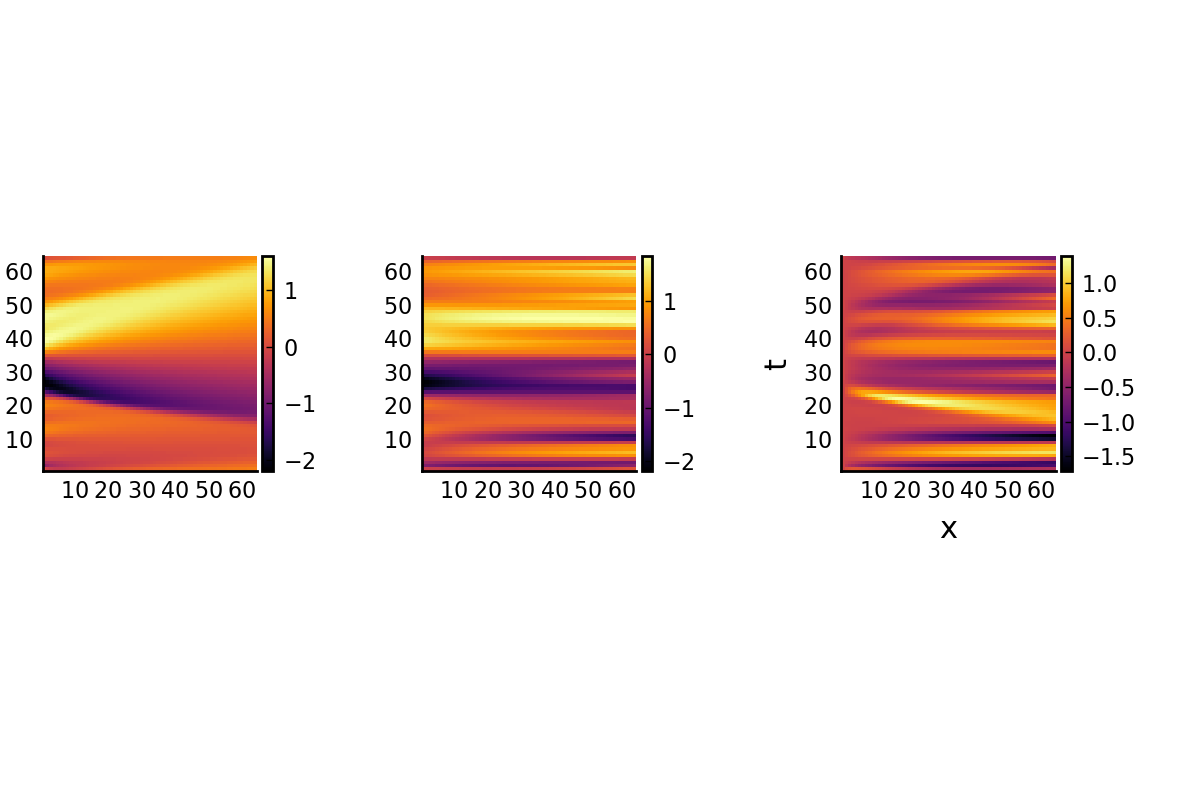

In [34]:
check_result(nn, p, 2)